In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from torch.utils.data import Subset
import numpy as np
from typing import List
from torchvision.datasets import ImageFolder

from VAE.models.info_vae import InfoVAE


In [12]:
def get_data_loader_prefix(root_dir, batch_size=64, prefixes: List[str] = ['afro']):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = ImageFolder(root=root_dir, transform=transform)

    selected_indices = [
        i for i, (path, _) in enumerate(dataset.samples)
        if any(os.path.basename(os.path.dirname(path)).lower().startswith(prefix.lower()) for prefix in prefixes)
    ]

    if not selected_indices:
        raise ValueError(f"Aucune image trouvée dans des dossiers commençant par: {prefixes}")

    selected_dataset = Subset(dataset, selected_indices)

    train_size = int(0.8 * len(selected_dataset))
    test_size = len(selected_dataset) - train_size
    train_dataset, test_dataset = random_split(selected_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return selected_dataset, train_loader, test_loader

def get_data_loader(root_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))

    ])

    dataset = datasets.ImageFolder(root=root_dir, transform=transform)


    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return dataset, train_loader, test_loader

'''def get_data_loader(root_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.CenterCrop(178),          # Supposons que les images soient au format 178x218 (comme CelebA)
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return dataset, train_loader, test_loader'''

# Exemple d'utilisation
root_dir = '../data_contour_patch2'  # Dossier racine où tous les peintres sont stockés dans des sous-dossiers
#dataset, train_loader, test_loader = get_data_loader_prefix(root_dir, batch_size=64, prefixes=['amiet'])
dataset, train_loader, test_loader = get_data_loader(root_dir, batch_size=64)

# Vérification : afficher le batch size et la taille des images pour l'entraînement
for data, labels in train_loader:
    print(f"Batch size: {data.size(0)} - Image size: {data.size(2)} x {data.size(3)}")
    break

print(f"Total images in dataset: {len(dataset)}")
print(f"Number of training batches: {len(train_loader)}")

Batch size: 64 - Image size: 64 x 64
Total images in dataset: 433755
Number of training batches: 5422


Image 1 - Min: 0.00, Max: 1.00
Image 2 - Min: 0.00, Max: 1.00
Image 3 - Min: 0.00, Max: 1.00
Image 4 - Min: 0.00, Max: 1.00
Image 5 - Min: 0.00, Max: 1.00


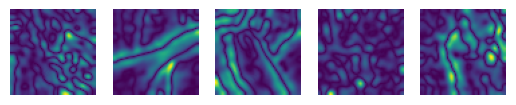

In [13]:

# Plot 5 random images from the test dataset (color images)
def plot_random_images(test_loader):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    images = (images+1)/2

    # Plot 5 random images from the batch
    for i in range(5):
        vmin, vmax = images[i].min(), images[i].max()
        print(f"Image {i+1} - Min: {vmin:.2f}, Max: {vmax:.2f}")
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0), vmin=vmin, vmax=vmax)  # Permute to (H, W, C) for RGB display
        plt.axis('off')
    
    plt.show()

plot_random_images(test_loader)



In [14]:
def plot_reconstructions(original, reconstructed, epoch):
    # Convertir les images en numpy
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    # Recaler les valeurs de [-1, 1] vers [0, 1]
    original = (original + 1) / 2
    reconstructed = (reconstructed + 1) / 2

    # Tracer les images
    fig, axes = plt.subplots(2, 4, figsize=(10, 4))
    for i in range(4):
        axes[0, i].imshow(original[i].transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.suptitle(f'Epoch {epoch} - Reconstructions', fontsize=16)
    plt.show()

In [ ]:
device = torch.device('cuda')

# Initialisation du modèle et de l'optimiseur
vae_model = InfoVAE(in_channels=1, latent_dim=64, reg_weight=50, kld_weight=1e-3).to(device)
optimizer = torch.optim.AdamW(vae_model.parameters(), lr=1e-3, weight_decay=1e-2)


n_epoch = 5 

Epoch 0:  82%|████████▏ | 4432/5422 [05:00<01:09, 14.26batch/s, kld=-14.2, loss=0.463, mmd=0.578, recons_loss=0.087]     

✅ Saved checkpoint to: weights/vae_checkpoint_epoch0_batch4430.pt


Epoch 0: 100%|██████████| 5422/5422 [06:05<00:00, 14.84batch/s, kld=-17.9, loss=0.42, mmd=-0.404, recons_loss=0.0797]   


Epoch 0: Train Loss: 0.4550


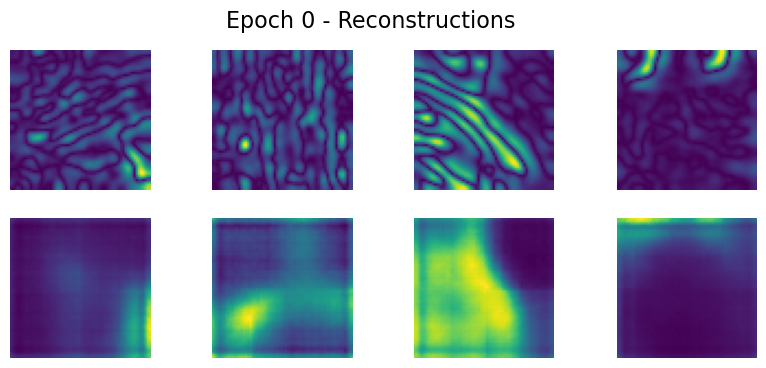

Epoch 1: 100%|██████████| 5422/5422 [02:56<00:00, 30.73batch/s, kld=-19.8, loss=0.417, mmd=1.1, recons_loss=0.0744]     


Epoch 1: Train Loss: 0.4123


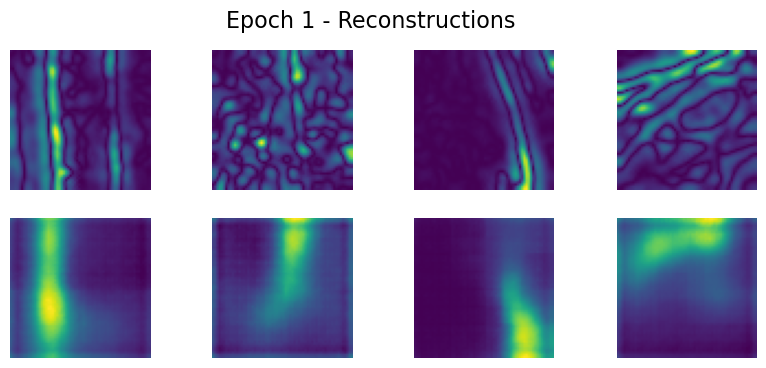

Epoch 2:  33%|███▎      | 1793/5422 [00:58<02:08, 28.13batch/s, kld=-19.7, loss=0.418, mmd=2.06, recons_loss=0.0727]    

✅ Saved checkpoint to: weights/vae_checkpoint_epoch2_batch1789.pt


Epoch 2: 100%|██████████| 5422/5422 [02:54<00:00, 31.02batch/s, kld=-20.8, loss=0.447, mmd=3.74, recons_loss=0.073]     


Epoch 2: Train Loss: 0.3987


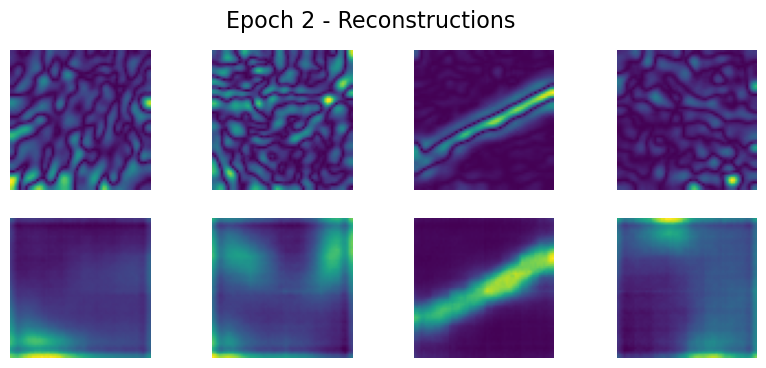

Epoch 3: 100%|██████████| 5422/5422 [02:55<00:00, 30.89batch/s, kld=-21.4, loss=0.365, mmd=-2.08, recons_loss=0.0722]   


Epoch 3: Train Loss: 0.3902


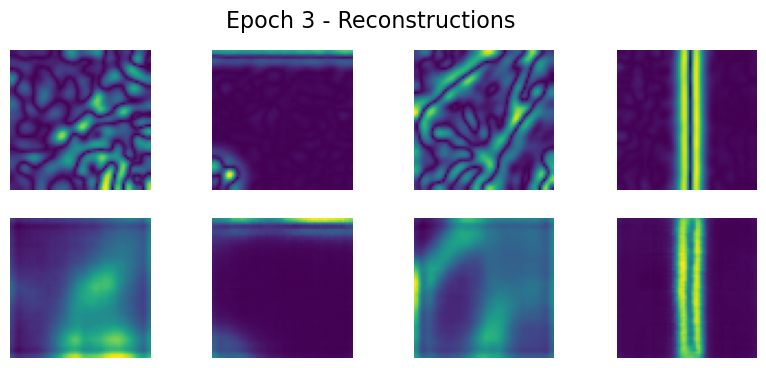

Epoch 4:   4%|▍         | 230/5422 [00:07<03:01, 28.57batch/s, kld=-23.5, loss=0.353, mmd=-3.27, recons_loss=0.0714]  

✅ Saved checkpoint to: weights/vae_checkpoint_epoch4_batch222.pt


Epoch 4: 100%|██████████| 5422/5422 [02:55<00:00, 30.90batch/s, kld=-24, loss=0.389, mmd=-2.52, recons_loss=0.0774]     


Epoch 4: Train Loss: 0.3842


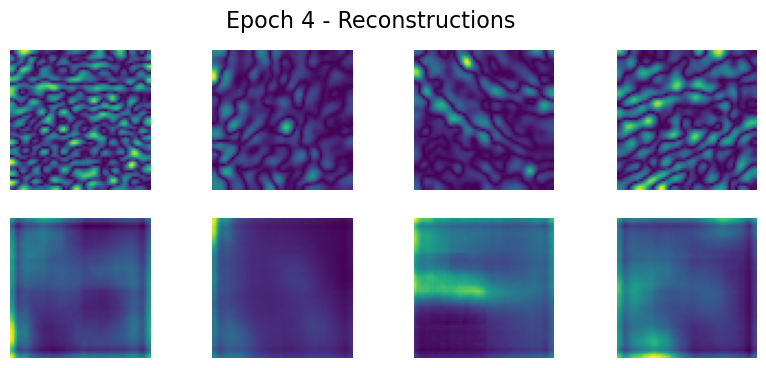

In [17]:
enable_checkpointing = True  # Set to True to enable periodic saving
time_interval = 20000
0  # Interval in seconds for plotting reconstructions
vae_model.train()

last_plot_time = time.time()  # For reconstructions
last_save_time = time.time()  # For saving

for epoch in range(n_epoch):
    train_loss = 0.0

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, _ in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            images = images.to(device)
            recons, input, z, mu, log_var = vae_model.forward(images)

            losses = vae_model.loss_function(recons, input, z, mu, log_var)
            loss = losses['loss']
            recons_loss = losses['Reconstruction_Loss']
            mmd = losses['MMD']
            kld = losses['KLD']

            vae_model.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item(), recons_loss=recons_loss.item(), kld=kld.item(), mmd=mmd.item())

            current_time = time.time()

            if enable_checkpointing and (current_time - last_save_time > 60*5):
                checkpoint_path = f"weights/vae_checkpoint_epoch{epoch}_batch{tepoch.n}.pt"
                torch.save({
                    'epoch': epoch,
                    'batch': tepoch.n,
                    'model_state_dict': vae_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                }, checkpoint_path)
                print(f"✅ Saved checkpoint to: {checkpoint_path}")
                last_save_time = current_time

            if current_time - last_plot_time > time_interval:
                with torch.no_grad():
                    plot_reconstructions(images, recons, f"{epoch}-{tepoch.n}")
                last_plot_time = current_time

    print(f'Epoch {epoch}: Train Loss: {train_loss / len(train_loader):.4f}')

    with torch.no_grad():
        plot_reconstructions(images, recons, epoch)


In [ ]:
import glob

# Find all checkpoint files in the weights directory
checkpoint_files = sorted(glob.glob("weights/vae_checkpoint_epoch*_batch*.pt"))

train_losses = []
test_losses = []
epochs = []
batches = []

for ckpt_path in checkpoint_files:
    checkpoint = torch.load(ckpt_path, map_location=device)
    vae_model.load_state_dict(checkpoint['model_state_dict'])
    vae_model.eval()
    
    # Record epoch and batch for x-axis
    epochs.append(checkpoint['epoch'])
    batches.append(checkpoint['batch'])
    train_losses.append(checkpoint['loss'])

    # Compute test loss on 1000 images only
    test_loss = 0.0
    num_images = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recons, input, mu, log_var = vae_model.forward(images)
            losses = vae_model.loss_function(recons, input, mu, log_var)
            batch_loss = losses['loss'].item()
            test_loss += batch_loss * images.size(0)  # accumulate weighted by batch size
            num_images += images.size(0)
            if num_images >= 1000:
                break
    test_loss /= min(num_images, 1000)
    test_losses.append(test_loss)

# Plot training and test loss curves
plt.figure(figsize=(10, 5))
plt.plot(batches, train_losses, label='Train Loss')
plt.plot(batches, test_losses, label='Test Loss (1000 images)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()


C:\Users\PresiJean\AppData\Local\Temp\ipykernel_14944\3409877146.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)

RuntimeError: PytorchStreamReader failed locating file data/2: file not found